# Tutorial 7
Inverse designing holograms.

Loss: -6.972081: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


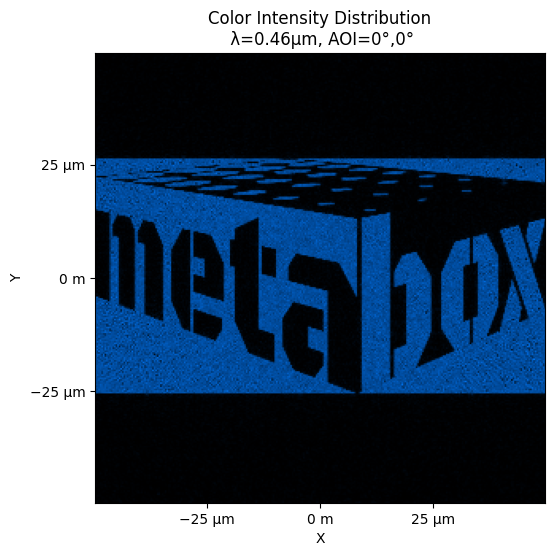

In [6]:
from metabox import modeling, assembly
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the metamodel we created in tutorial 0.
metamodel = modeling.load_metamodel('TiO2_square', '/home/huang/research/metabox/dev/test_models')

# Create a metasurface.
metasurface = assembly.Metasurface(
    diameter=100e-6,              # 100 microns in diameter
    refractive_index=1.0,         # the propagation medium after the metasurface
    thickness=100e-6,             # the distance to the next surface
    metamodel=metamodel,          # the metamodel to use
    enable_propagator_cache=True, # cache the propagators for faster computation
    set_structures_variable=True, # set the structures as a variable to optimize
    use_circular_expansions=False,
)

# Define the incidence wavelengths and angles.
incidence = assembly.Incidence(wavelength=[460e-9])

# Create figure of merit.
# read image
img = tf.cast(Image.open('../images/metabox.png').convert('L'), tf.float32)
data = {'target': assembly.IntensityTarget(img)}
# Create a custom figure of merit as '-log(target.dist(psf[0]))
custom_fom = assembly.CustomFigureOfMerit("-log(target.dist(psf[0]))", data=data)

# Create a lens assembly.
lens_assembly = assembly.LensAssembly(
        surfaces=[metasurface], # Define the array of surfaces. Here only one.
        incidence=incidence,
        figure_of_merit=custom_fom, 
)

# Use the Adam optimizer to optimize the lens assembly. This rate should be
# empirically determined.
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-8
)
optimizer.build(lens_assembly.get_variables())

# Optimize the lens assembly. Returns the best-optimized lens assembly and the loss history.
history = assembly.optimize_single_lens_assembly(
    lens_assembly, 
    optimizer, 
    n_iter=50,
    verbose=1,
    keep_best=True,
)

# plot the color PSF
lens_assembly.show_color_psf()

In [3]:
# Export the hologram metasurface to GDS.
from metabox import export
export.generate_gds(metasurface, 0, 'tutorial_7_metabox_hologram', export_directory="./example_folder")

Loss: -4.796171: 100%|██████████| 50/50 [02:15<00:00,  2.72s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


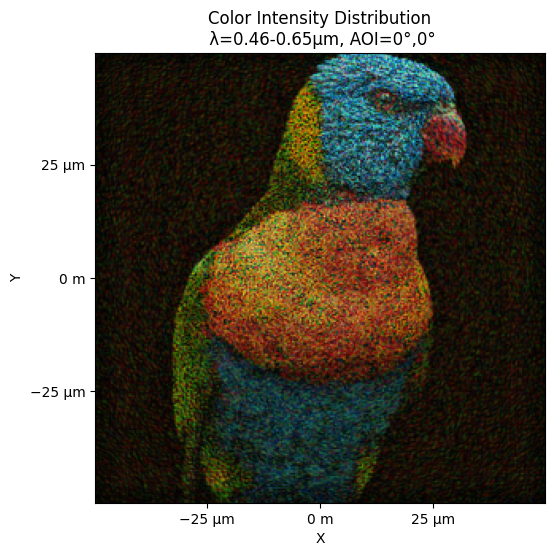

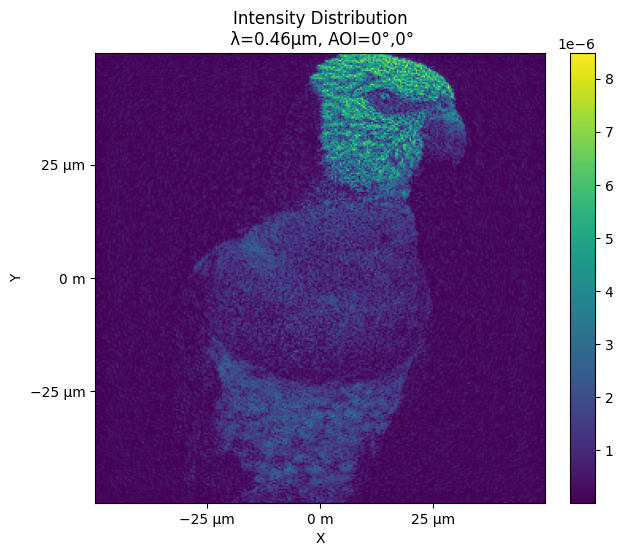

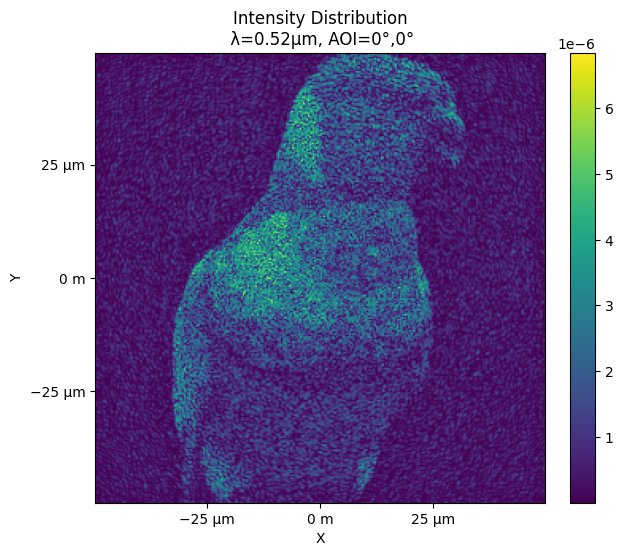

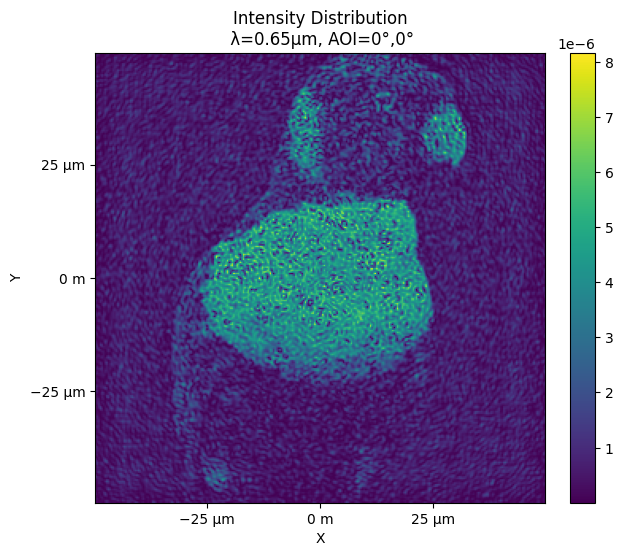

In [5]:
# a more complicated example
from metabox import modeling, assembly
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the metamodel we created in tutorial 0.
metamodel = modeling.load_metamodel('TiO2_square', '/home/huang/research/metabox/dev/test_models')

# Create a metasurface.
metasurface = assembly.Metasurface(
    diameter=100e-6,              # 100 microns in diameter
    refractive_index=1.0,         # the propagation medium after the metasurface
    thickness=100e-6,             # the distance to the next surface
    metamodel=metamodel,          # the metamodel to use
    enable_propagator_cache=True, # cache the propagators for faster computation
    set_structures_variable=True, # set the structures as a variable to optimize
    use_circular_expansions=False,
)

# Define the incidence wavelengths and angles.
incidence = assembly.Incidence(
    wavelength=[460e-9, 525e-9, 650e-9], 
    jones_vector=[1, 1], # linear polarization along x
)

# Create figure of merit.
# read image
img = tf.cast(Image.open('/home/huang/research/metabox/images/colorful_bird.jpg'), tf.float32)
# Make the data dictionary. Split the image into three channels.
data = {
    'r_targ': assembly.IntensityTarget(img[:, :, 2]),
    'g_targ': assembly.IntensityTarget(img[:, :, 1]),
    'b_targ': assembly.IntensityTarget(img[:, :, 0]),
}
expression = "-log(r_targ.dist(psf[0, :, :]) + g_targ.dist(psf[1, :, :]) + b_targ.dist(psf[2, :, :]))"
custom_fom = assembly.CustomFigureOfMerit(expression, data=data)

# Create a lens assembly.
lens_assembly = assembly.LensAssembly(
        surfaces=[metasurface], # Define the array of surfaces. Here only one.
        incidence=incidence,   # Define the incidence.
        figure_of_merit=custom_fom, # Define the figure of merit.
)

# Use the Adam optimizer to optimize the lens assembly. This rate should be
# empirically determined.
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-8
)
optimizer.build(lens_assembly.get_variables())

# Optimize the lens assembly. Returns the best-optimized lens assembly and the loss history.
history = assembly.optimize_single_lens_assembly(
    lens_assembly, 
    optimizer, 
    n_iter=50,
    verbose=1,
    keep_best=True,
)

# Plot the intensity of the PSF, in color and single channels.
lens_assembly.show_color_psf()
lens_assembly.show_psf()

In [ ]:
# Export the hologram metasurface to GDS.
from metabox import export
export.generate_gds(metasurface, 0, 'tutorial_7_bird_hologram', export_directory="./example_folder")